# 3D Overthrust data - POCS with irregular sampling along the x-axis

## Author: M.Ravasi

This notebook applies seismic interpolation to a 3D shot gather of the SEG/EAGE Overthrust 3D dataset. The data is subsampled along the x-axis and fully sampled along the y-axis.

The famous POCS method (which we show to be a special instance of HQS) will be applied to the data and compared to two other popular algorithm in convex optimazion, namely L-ADMM and PD.

The notebook is organized as follows:

- data loading
- direct arrival mask creation
- non-stationary data shifting (alternatively one could use NMO correction)
- FK mask creation
- interpolation with various algorithms

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.io as sp_io
import pylops

try:
    import cupy as cp
except:
    print('Cupy not available...')

from scipy.signal import convolve

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.signalprocessing.patch3d   import patch3d_design

from pyproximal.proximal import *
from pyproximal.optimization.primal import *

from pypocs.visual import explode_volume
from pypocs.interpolation import pocs_interpolate, admm_interpolate, hqs_interpolate, pd_interpolate
from pypocs.sampling import *
from pypocs.metric import *

## Parameters

In [2]:
# Global parameters
perc_subsampling = 3 # percentage of subsampling (if decimal, random subsample; if integer, regular subsampling)
verb = False # verbosity during reconstruction
skipdone = True # skip experiment if the result is already available in the experiments folder

# Windows for patching
nwin = (32, 32, 32) # size of the window
nover = (8, 8, 6) # overlap between windows
ixpatch, iypatch, itpatch = 1, 3, 2 # indices of the patch to visualize for QC

# FK mask
nfft = 2**8
critical = 1.00
koffset = 0.005
vel = 1500
fmax = 80

# Iterative solution
niter = 80
jsrnsave = 4

# Experiments (each list should have the same number of elements and this identifies the total number of experiments performed in this notebook)
affines     = [True,             True,              True]
identityops = [True,             False,             False]
norms =       [L0,               L0,                L0]
threshs =     [None,             [.05],             [.07]]
fkmasks =     [False,            False,             False]
algs =        [hqs_interpolate,  admm_interpolate,  pd_interpolate]

## Loading data

In [3]:
# Source
isrc = 3338*4 # selected source
print('Source:', isrc)

# Model size
ny, nx, nz = 200, 330, 155

# Data size
nt, nrxorig, nryorig = 1126, 177, 90
nrx, nry = 176, 80
dt = 0.004
dx = 20

data = np.fromfile('../../data/Overthrust//p_full%d.rsf@' % isrc, dtype='float32')
data = data.reshape(nt+75, nrxorig * nryorig)[75:]
data = data.reshape(nt, nryorig, nrxorig).transpose(2,1,0) # y,x,t
data = data[:nrx, :nry, :500]/np.max(np.abs(data[:nrx, :nry, :500]))

ns, nr, nt = data.shape
print(data.shape)

Source: 13352
(176, 80, 500)


## Define subsampling operator

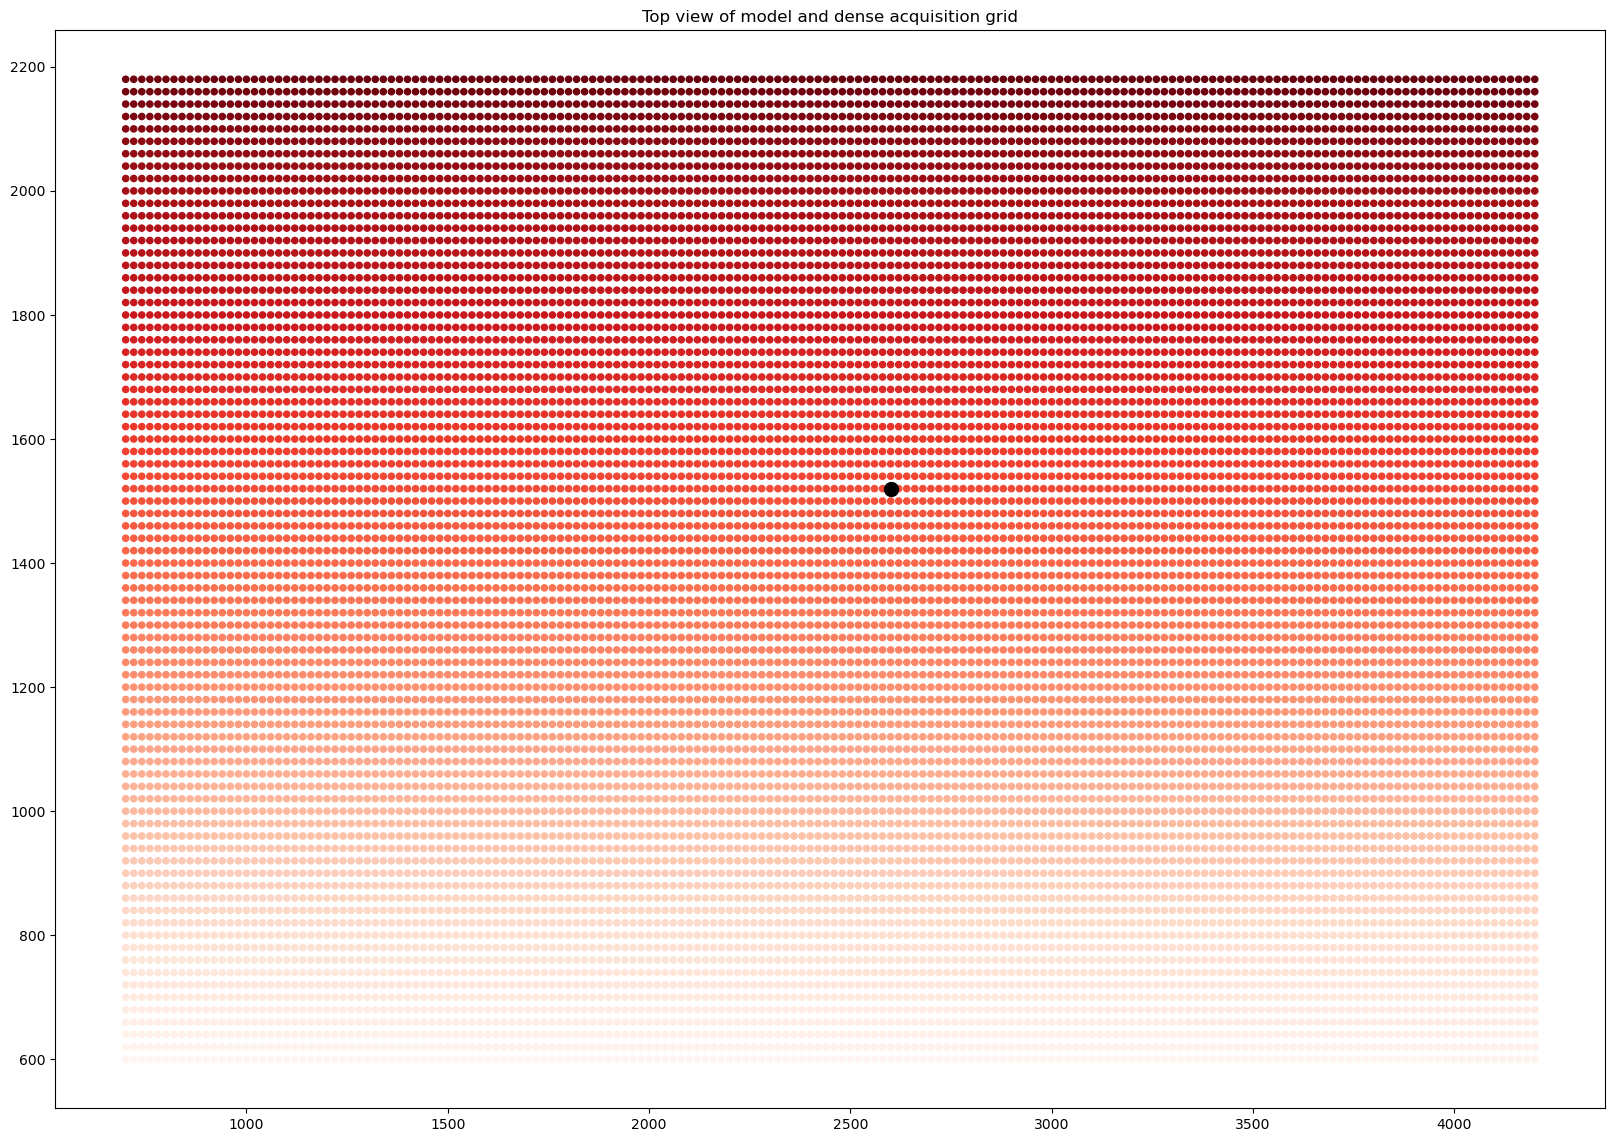

In [4]:
# Model
y, x, z = np.arange(ny)*15., np.arange(nx)*15., np.arange(nz)*15.

# Acquisition
srcx = np.arange(300,x[-1]-300, 20)
srcy = np.arange(300,y[-1]-300, 20)

SRCY, SRCX = np.meshgrid(srcy, srcx, indexing='ij')
SRCX, SRCY = SRCX.ravel(), SRCY.ravel()

recx = np.arange(700,x[-1]-700, 20)[:nrx]
recy = np.arange(600,y[-1]-600, 20)[:nry]

RECY, RECX = np.meshgrid(recy, recx, indexing='ij')
RECX, RECY = RECX.ravel(), RECY.ravel()

plt.figure(figsize=(20, 14))
plt.scatter(RECX, RECY, c=np.arange(len(RECX)), s=20, cmap='Reds')
plt.scatter(SRCX[isrc], SRCY[isrc], c='k', s=100)
plt.title('Top view of model and dense acquisition grid');

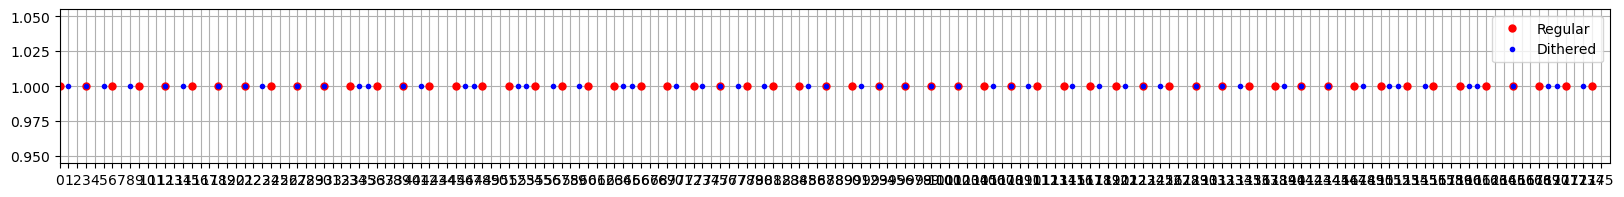

In [5]:
# subsampling locations
plt.figure(figsize=(20, 2))

if perc_subsampling < 1:
    iava = irregular(ns, perc_sub=perc_subsampling, seed=10)

    plt.plot(iava, np.ones(len(iava)), '.b')
    plt.xticks(np.arange(ns));
    plt.grid(which='both')
    plt.xlim(0, nr)
else:
    iava, iava_reg = dithered_irregular(ns, factor_sub=perc_subsampling, seed=10)
    plt.plot(iava_reg, np.ones(len(iava_reg)), '.r', ms=10, label='Regular')
    plt.plot(iava, np.ones(len(iava)), '.b', label='Dithered')
    plt.xticks(np.arange(ns));
    plt.grid(which='both')
    plt.xlim(0, ns)
    plt.legend()

# Create restriction operator
Rop = Restriction(dims=(ns, nr, nt), iava=iava, axis=0, dtype='float64')
datamasked = Rop.H*Rop*data
mask = Rop.H*Rop*np.ones_like(data)

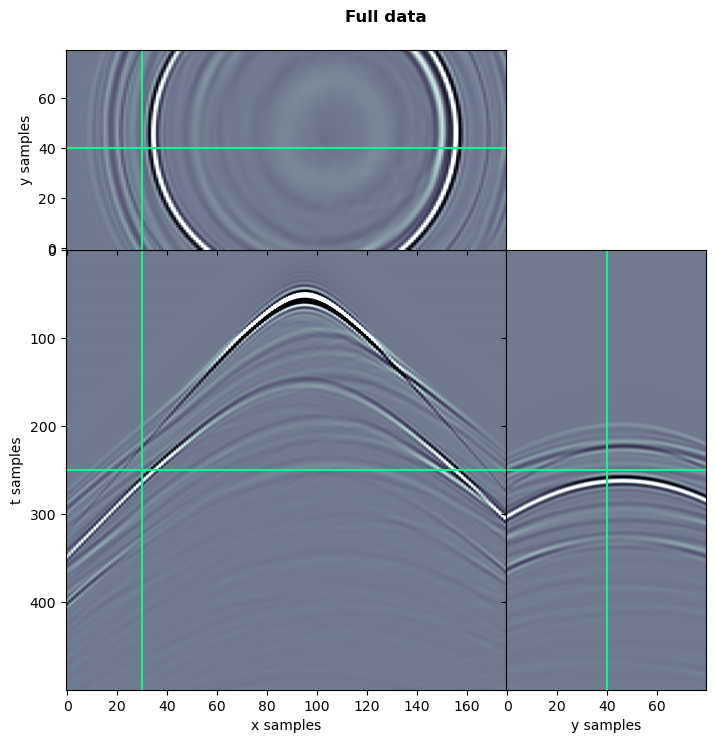

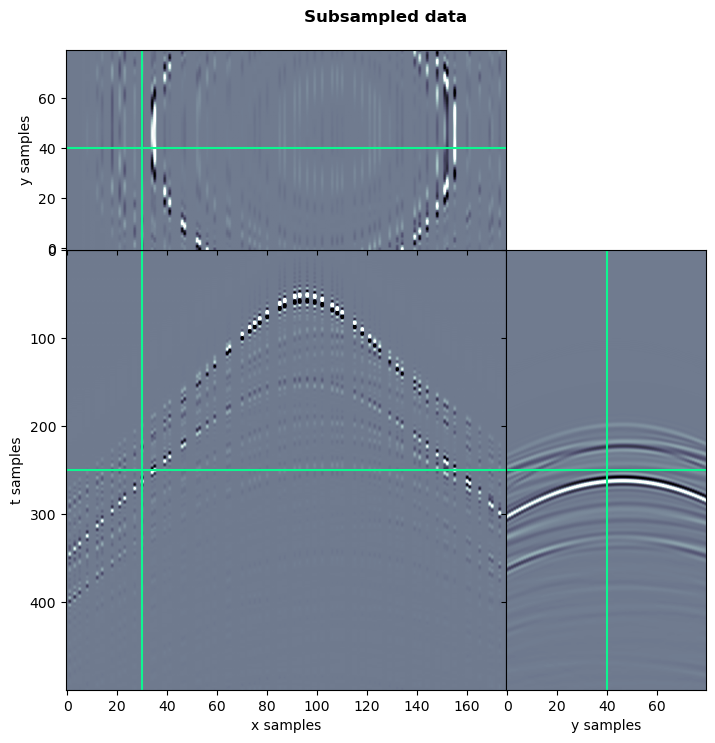

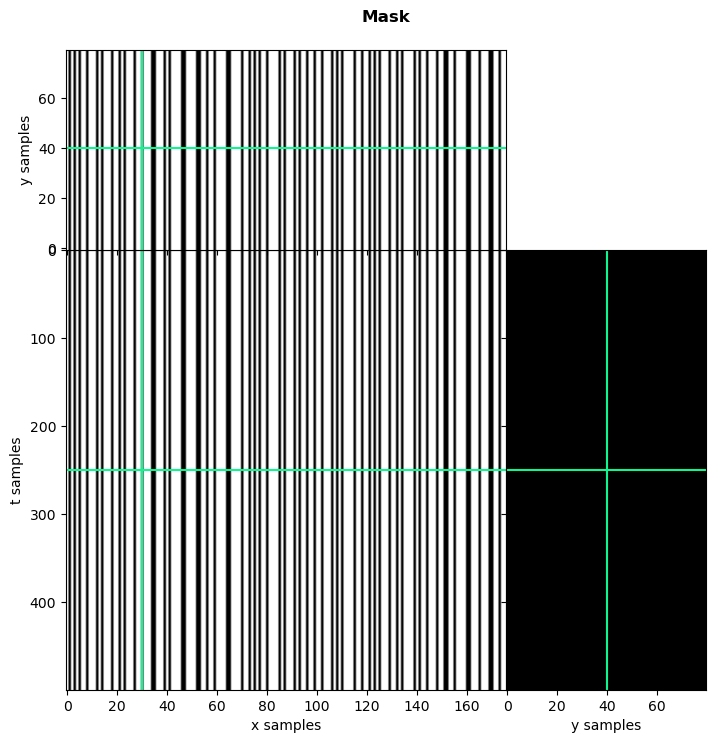

In [6]:
explode_volume(data.transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title='Full data')
explode_volume(datamasked.transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title='Subsampled data')
explode_volume(mask.transpose(2, 0, 1), x=30, cmap='gray_r', clipval=(0, 1), figsize=(8, 8), title='Mask');

## Pre-processing

### Create direct arrival mask

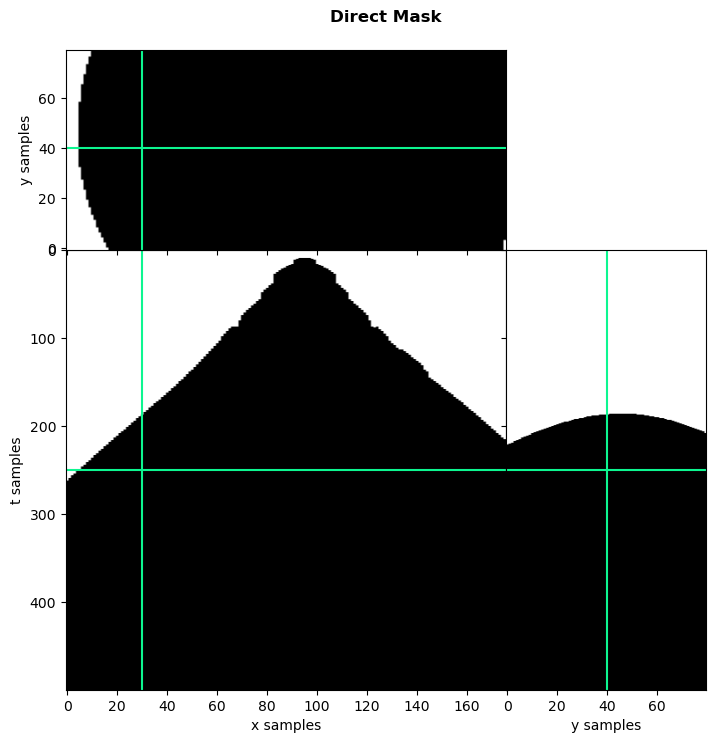

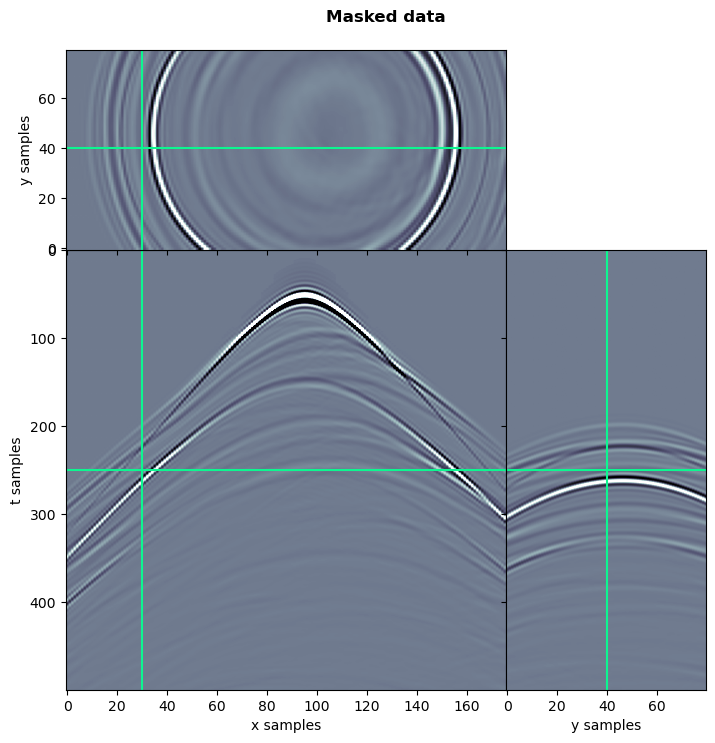

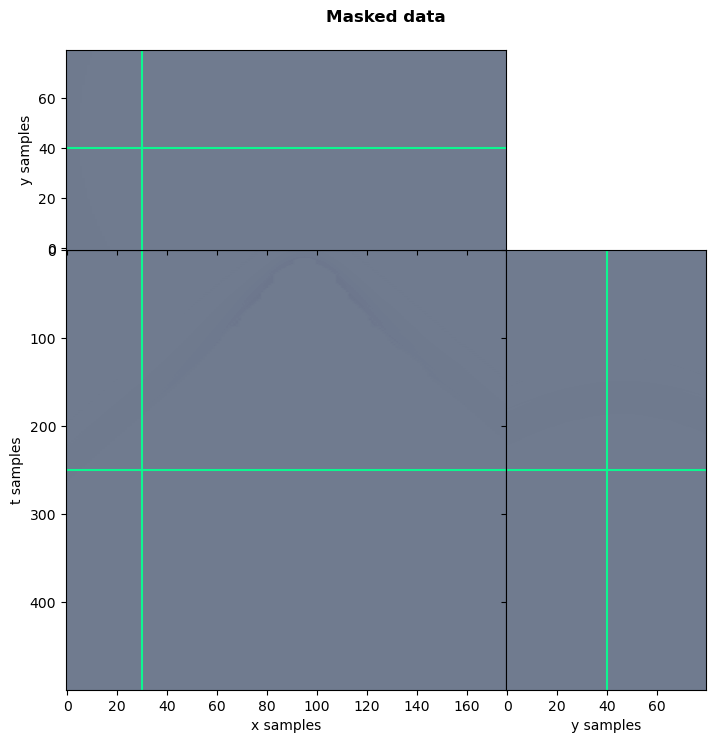

In [7]:
direct_mask = np.ones_like(data)
thresh = 0.01 * np.max(np.abs(data))
for iy in range(ns):
    for ix in range(nr):
        direct_mask[iy, ix, :max(0, np.where(np.abs(data[iy, ix]) > thresh)[0][0]-10)] = 0.

explode_volume(direct_mask.transpose(2, 0, 1), x=30, cmap='gray_r', clipval=(0, 1), figsize=(8, 8), title='Direct Mask')    
explode_volume((direct_mask*data).transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title='Masked data')
explode_volume(((1-direct_mask)*data).transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title='Masked data');

### Divide data in patches

 468], end:[ 32  58  84 110 136 162 188 214 240 266 292 318 344 370 396 422 448 474
 500]
 576], end:[ 32  64  96 128 160 192 224 256 288 320 352 384 416 448 480 512 544 576
 608]


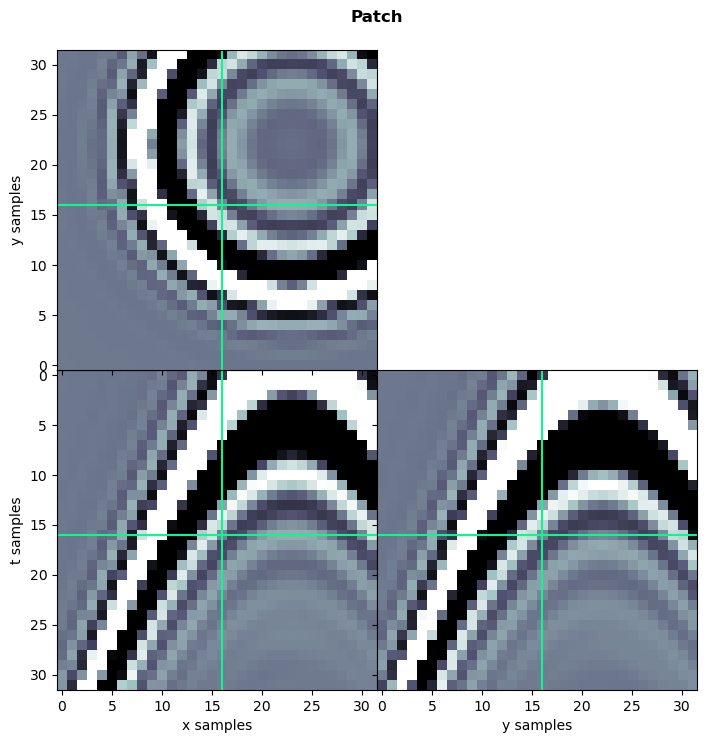

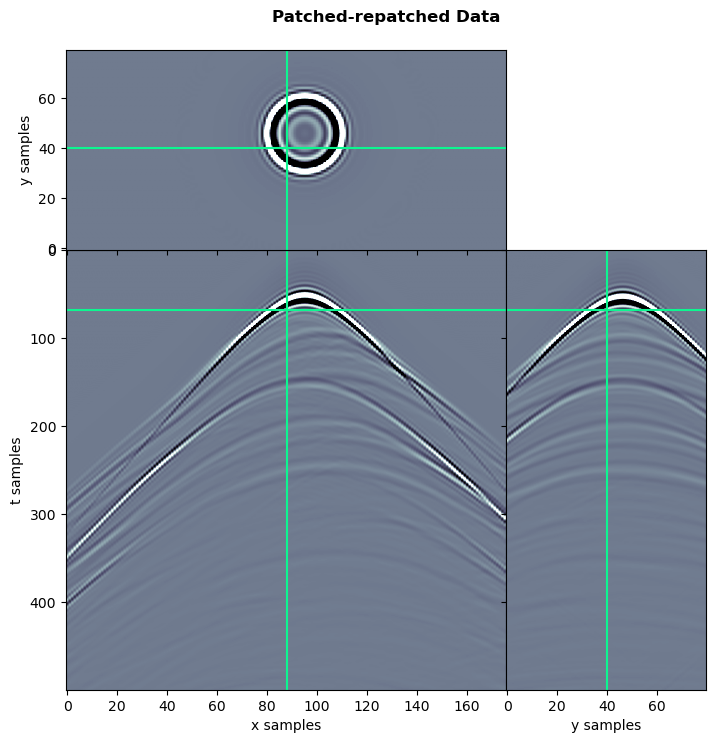

In [8]:
dimsd = data.shape
nwins, dims, mwins_inends, dwins_inends = patch3d_design(dimsd, nwin, nover, nwin)

Op = Identity(nwin[0]*nwin[1]*nwin[2], nwin[0]*nwin[1]*nwin[2])
Sop = Patch3D(Op.H, dims, dimsd, nwin, nover, nwin, tapertype=None)
Srecop = Patch3D(Op.H, dims, dimsd, nwin, nover, nwin, tapertype='cosine')
patches = Sop.H * data
patchesmasked = Sop.H * datamasked
patchesmask = Sop.H * mask
databench = Srecop * patches

Op = Identity(nr, ns)
S1op = Sliding1D(Identity(nwin[0], nwin[0]), dims[0], dimsd[0], nwin[0], nover[0], tapertype=None)
mask1d = np.zeros(ns)
mask1d[iava] = 1
mask1d_patches = S1op.H * mask1d

explode_volume(patches[iypatch, ixpatch, itpatch].transpose(2, 0, 1), clipval=(-0.2,0.2), figsize=(8, 8), 
               title='Patch')
explode_volume(databench.transpose(2, 0, 1), 
               t=(dwins_inends[2][0][itpatch] + dwins_inends[2][1][itpatch]) // 2,
               y=(dwins_inends[1][0][ixpatch] + dwins_inends[1][1][ixpatch]) // 2,
               x=(dwins_inends[0][0][iypatch] + dwins_inends[0][1][iypatch]) // 2,
               clipval=(-0.2,0.2), figsize=(8, 8), title='Patched-repatched Data');

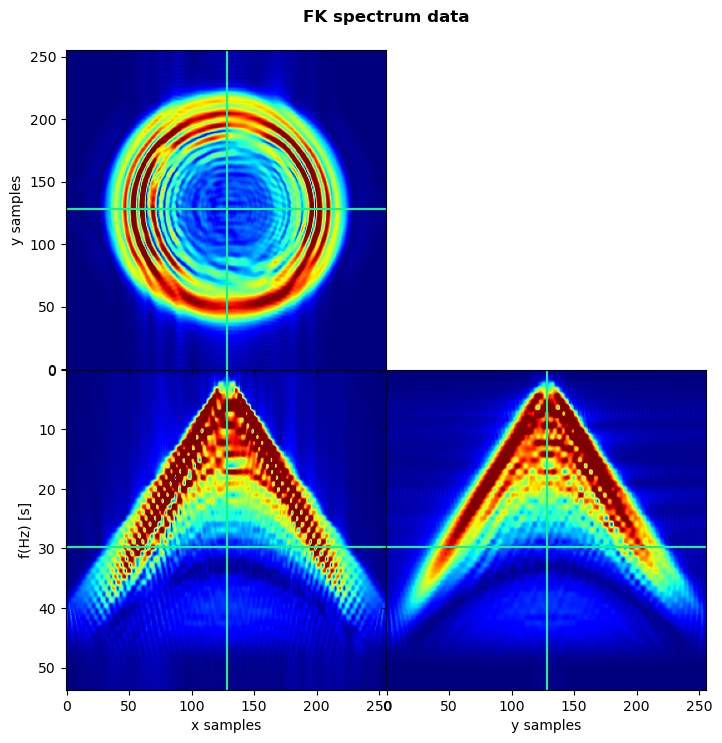

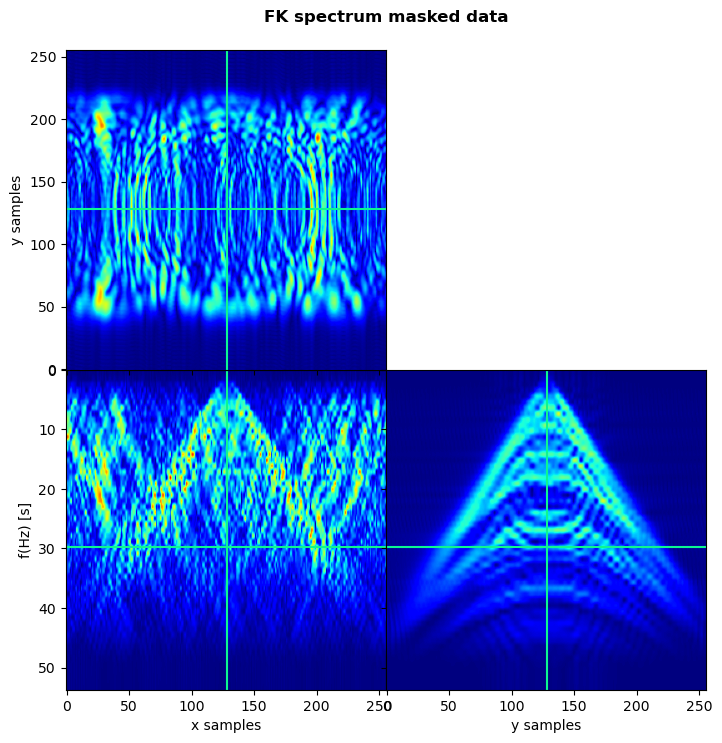

In [9]:
FFTop = FFTND(dims=[ns, nr, nt], nffts=[nfft, nfft, nfft], sampling=[dx, dx, dt], real=True)

datafk = FFTop @ data
datamaskedfk = FFTop @ datamasked

explode_volume(np.fft.fftshift(np.abs(datafk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=30,
               tlim=[0,FFTop.fs[-1][55]], tlabel='f(Hz)',
               cmap='jet', figsize=(8, 8), clipval=(0,0.2), title='FK spectrum data')

explode_volume(np.fft.fftshift(np.abs(datamaskedfk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=30,
               tlim=[0,FFTop.fs[-1][55]], tlabel='f(Hz)',
               cmap='jet', figsize=(8, 8), clipval=(0,0.2), title='FK spectrum masked data');

### Shift data

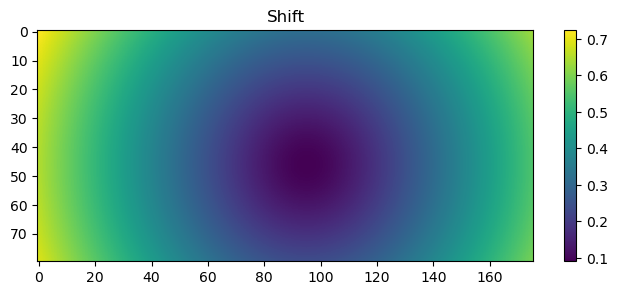

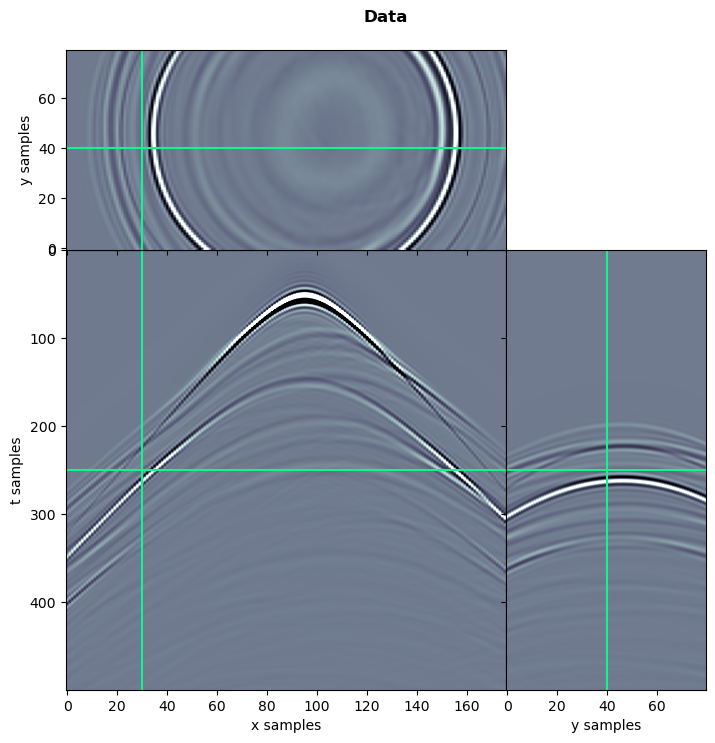

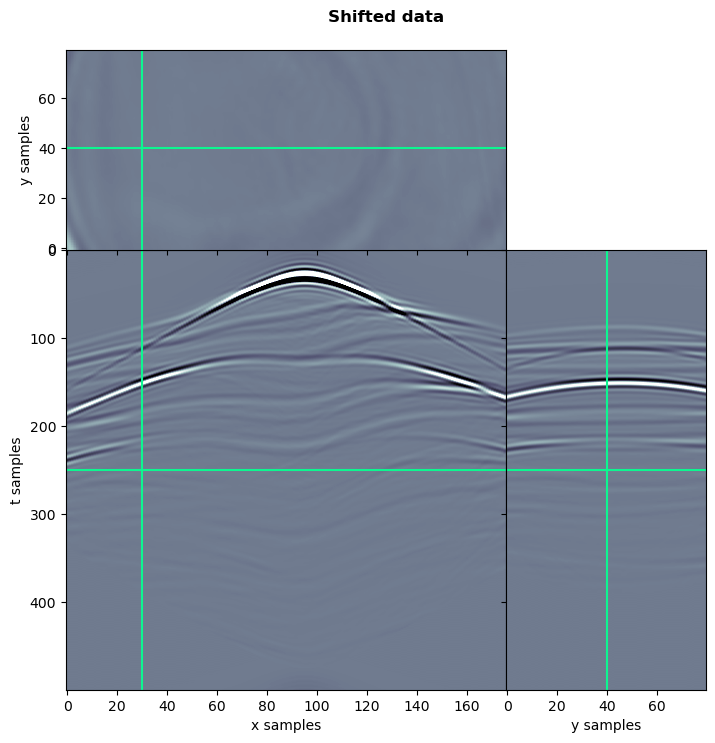

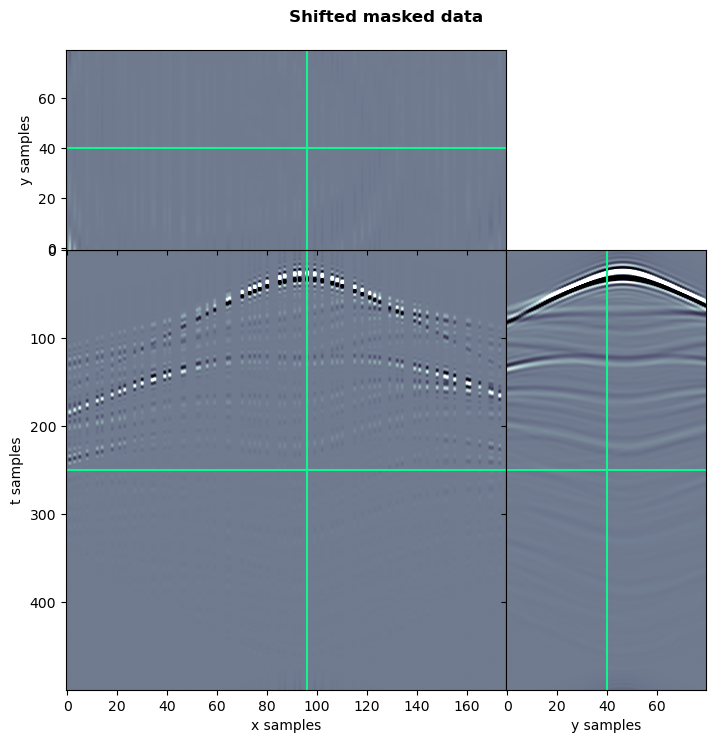

In [10]:
v = 4000
shift = np.power((300-10)**2 +
                (RECX.reshape(nry, nrx)-SRCX[isrc])**2 + 
                (RECY.reshape(nry, nrx)-SRCY[isrc])**2, 0.52) / v

plt.figure(figsize=(8, 3))
plt.imshow(shift)
plt.axis('tight')
plt.colorbar()
plt.title('Shift')

Shiftop = Shift((nrx, nry, nt), shift=-shift.T, sampling=dt, axis=2)
datashifted = np.real(Shiftop * data)
datareshifted = np.real(Shiftop.H * datashifted)
datashiftedmasked = Rop.H*Rop*datashifted

explode_volume(data.transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title='Data')
explode_volume(datashifted.transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title='Shifted data')
explode_volume(datashiftedmasked.transpose(2, 0, 1), x=96, clipval=(-0.2,0.2), figsize=(8, 8), title='Shifted masked data');

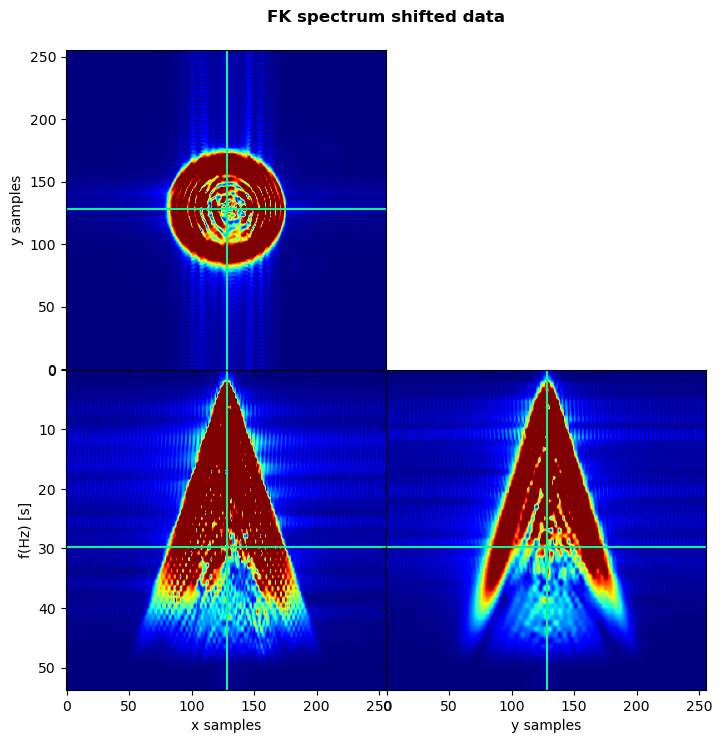

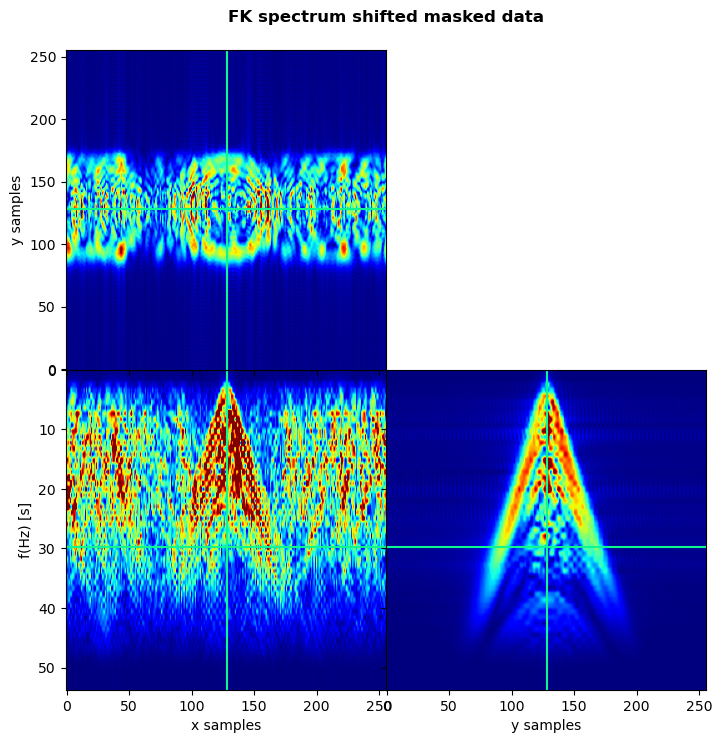

In [11]:
# FK spectra
datashiftedfk = FFTop @ datashifted
datashiftedmaskedfk = FFTop @ datashiftedmasked

explode_volume(np.fft.fftshift(np.abs(datashiftedfk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=30,
               tlim=[0,FFTop.fs[-1][55]], tlabel='f(Hz)',
               cmap='jet', figsize=(8, 8), clipval=(0,0.2), title='FK spectrum shifted data')

explode_volume(np.fft.fftshift(np.abs(datashiftedmaskedfk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=30,
               tlim=[0,FFTop.fs[-1][55]], tlabel='f(Hz)',
               cmap='jet', figsize=(8, 8), clipval=(0,0.2), title='FK spectrum shifted masked data');

In [12]:
# Shift data and make patches ready for interpolation
patchesshifted = Sop.H * datashifted
patchesshiftedmasked = Sop.H * datashiftedmasked

### Create FK mask

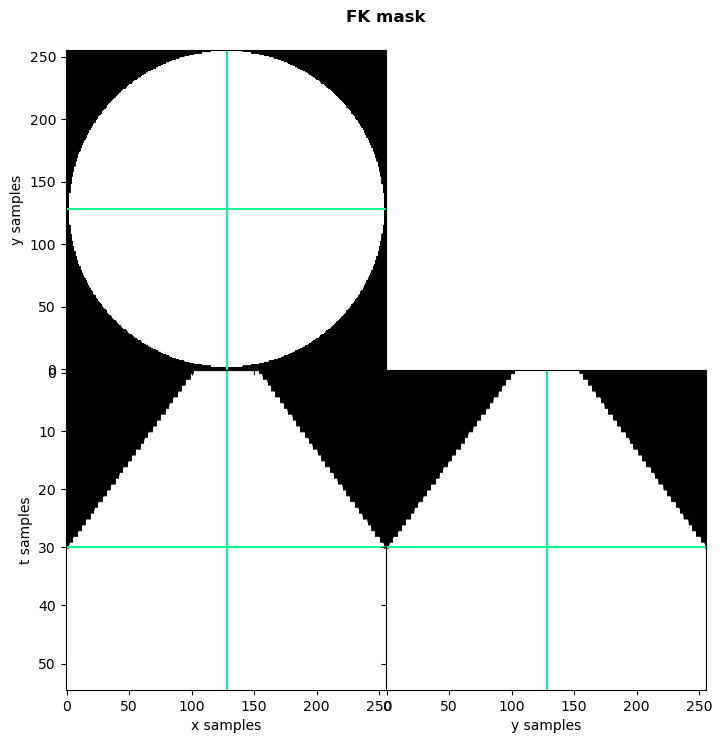

In [13]:
FFT1op = FFTND(dims=nwin, nffts=[nfft, nfft, nfft], sampling=[dx, dx, dt], real=True)

ky = FFT1op.fs[0]
kx = FFT1op.fs[1]
f1 = FFT1op.fs[2]

fmask = np.zeros(nfft//2+1)
fmask[np.abs(f1)<fmax] = 1

[KY, KX, FF] = np.meshgrid(ky, kx, f1, indexing='ij')
fkmask = np.sqrt(np.abs(KX)**2 + np.abs(KY)**2) < (critical*np.abs(FF)/vel + koffset)
fkmask = fkmask.T
fkmask *= fmask[:, np.newaxis, np.newaxis].astype(bool)
fkmask = fkmask.astype(np.int).T

Mf = Diagonal(cp.asarray(fkmask.astype(np.int)), dtype='complex')
                  
explode_volume(np.fft.fftshift(fkmask[..., :55], axes=(0,1)).transpose(2, 1, 0), 
               t=30, cmap='gray', figsize=(8, 8), clipval=(0,0.2), title='FK mask');

In [14]:
# Sava subsampled data
np.savez(f'../../experiments/Overthrust/Rec_irreg{perc_subsampling}_data.npz', 
         data=data,
         direct_mask=direct_mask,
         mask=mask,
         datamasked=datamasked)

## Run experiments

In [15]:
datarec_shiftedback = {}
error_shifted = {}
snr_shifted = {}

Skipping Affine_IdopTrue_L0_ThNone_hqs_interpolate_niter80 (already available)
Working with Affine_IdopFalse_L0_Th[0.05]_admm_interpolate_niter80
Working with slice 0/7
thesh=[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]
ADMM interpolation
f=<pyproximal.proximal.AffineSet.AffineSet object at 0x14c1b2812280>
g=<pyproximal.proximal.L0.L0 object at 0x14c1b2812100>
K=<8454144x32768 _FFTND_numpy with dtype=complex128>
tau=0.99, mu=0.99
solver=LinearizedADMM
Working with slice 1/7
Working with slice 2/7
Working with slice 3/7
Working with slice 4/7
Working with slice 5/7
Working with slice 6/7
RMSE=0.1489590236265734, SNR=16.53866365998574

S

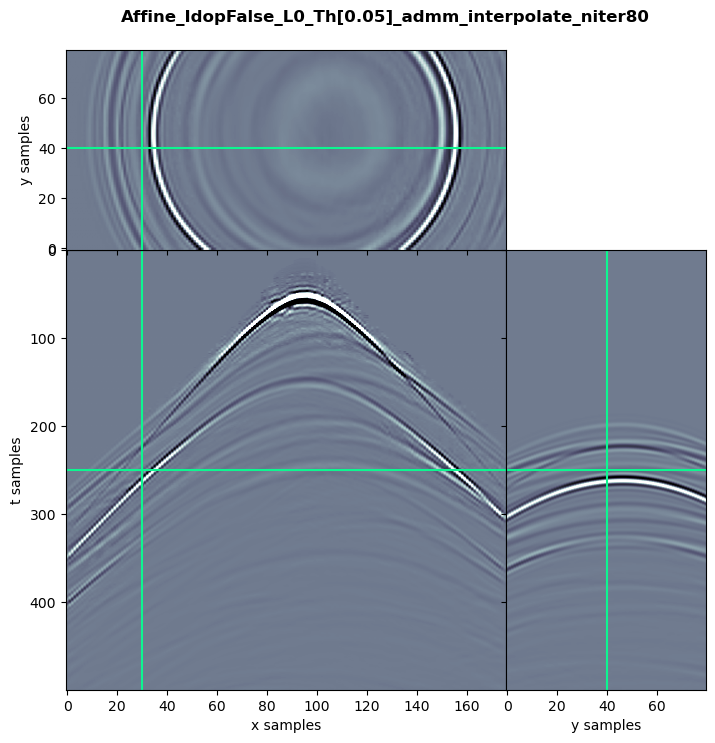

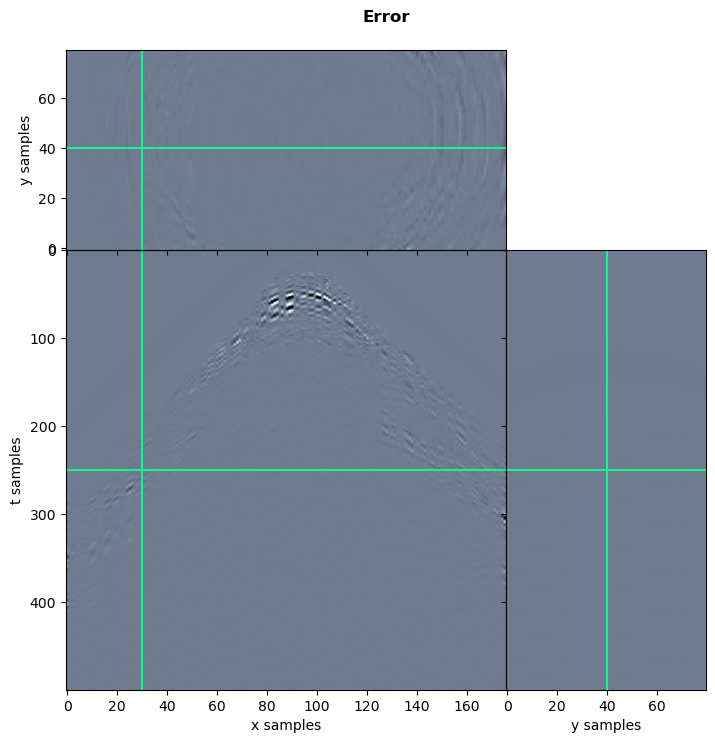

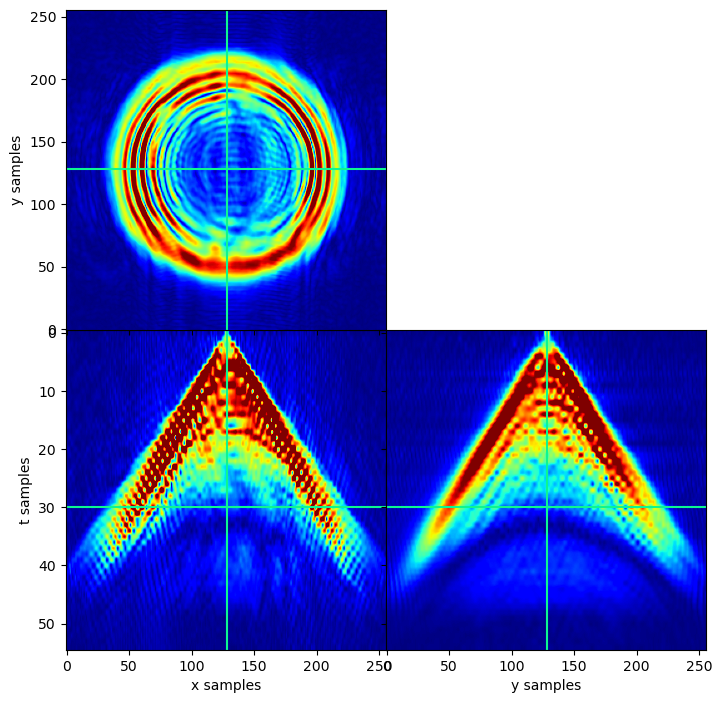

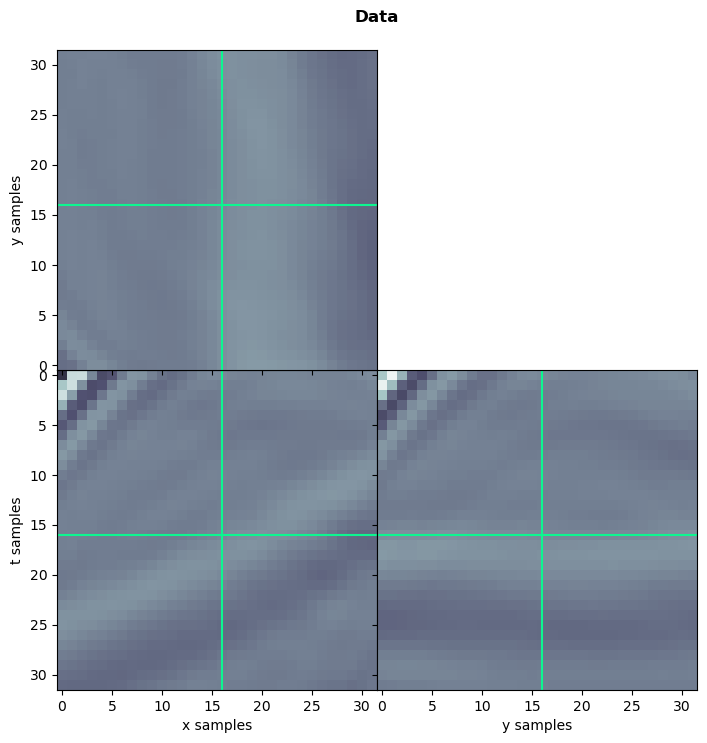

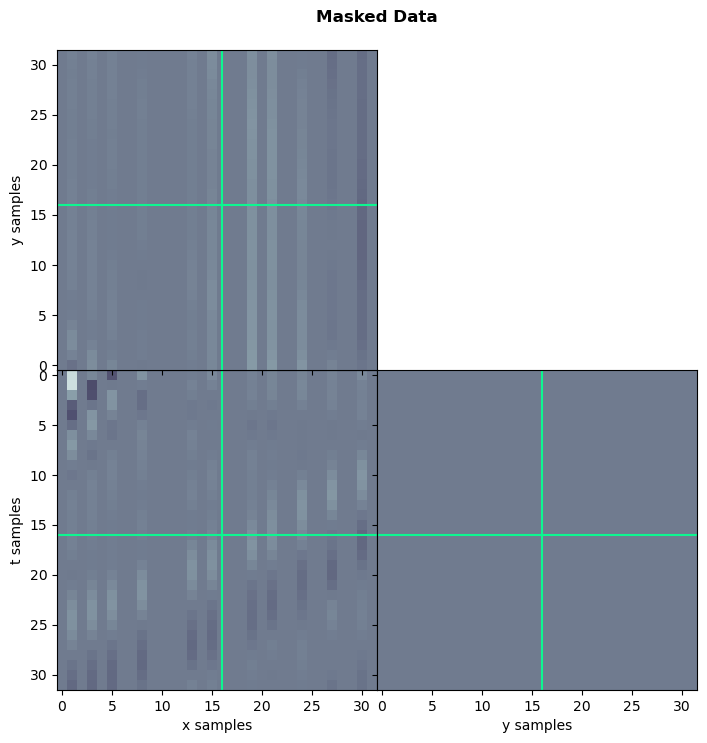

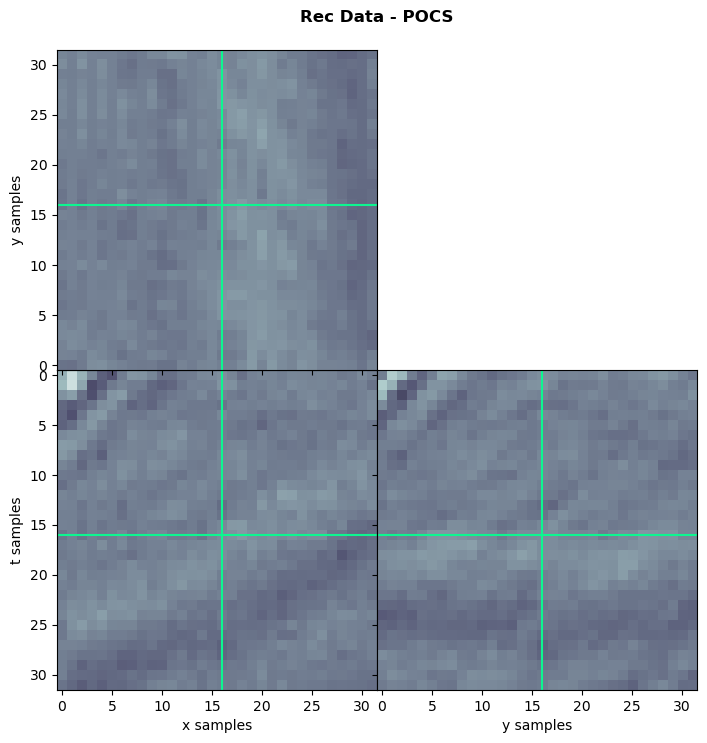

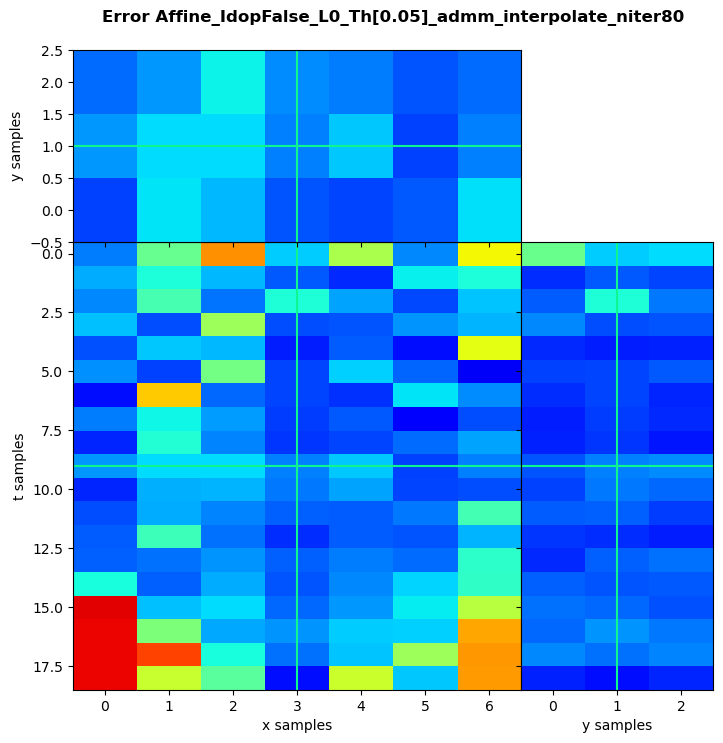

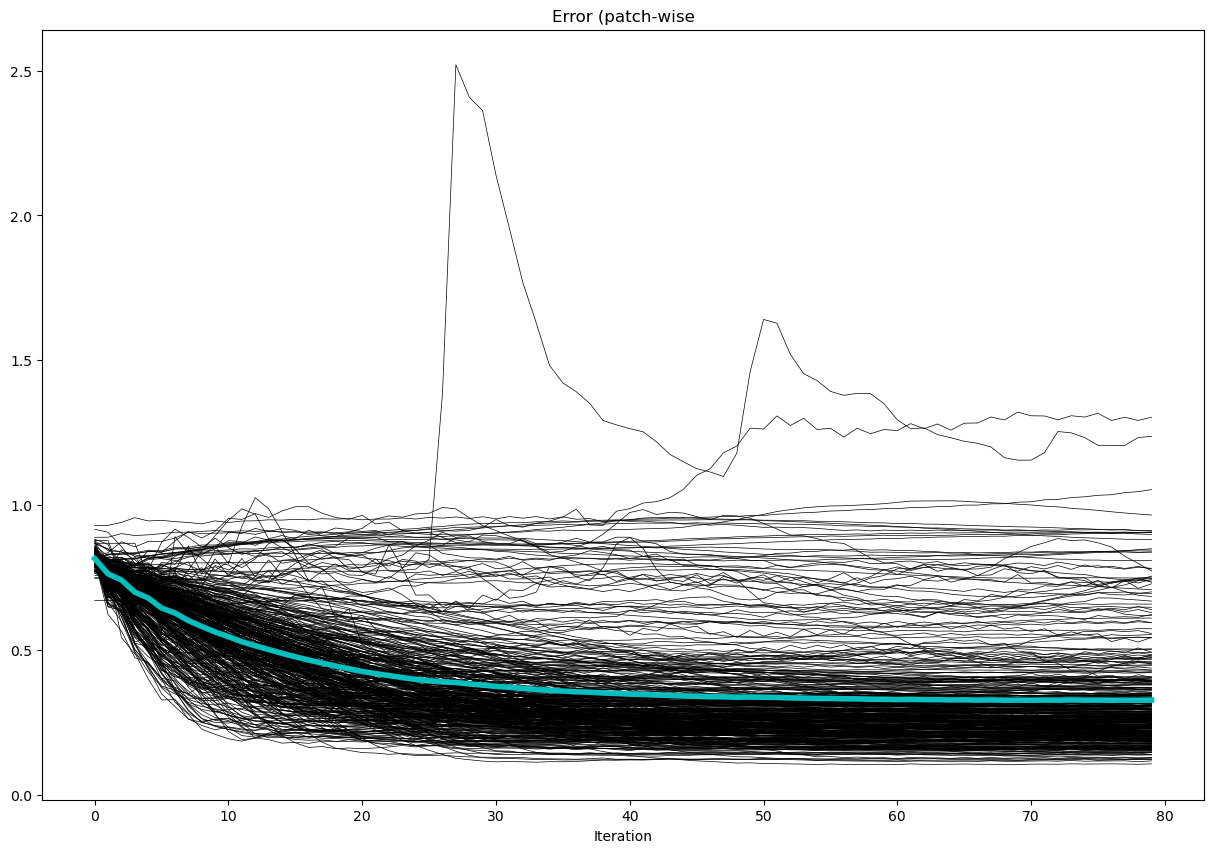

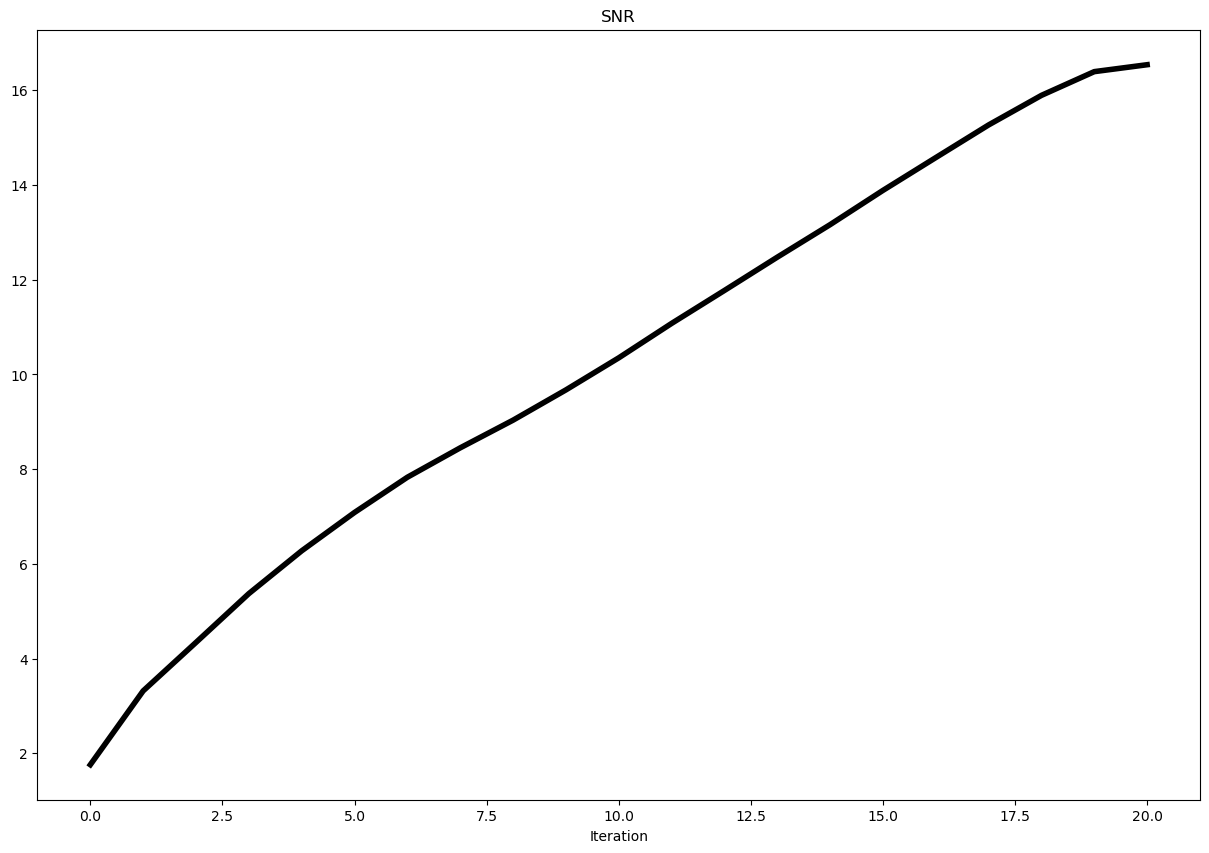

In [16]:
for affine, identityop, norm, thresh, fkmask, alg in zip(affines, identityops, norms, threshs, fkmasks, algs):
    
    normlabel = norm if isinstance(norm, str) else str(norm).split('.')[-1][:-2] 
    fkmasklabel = '_fkmask' if fkmask else ''
    label = ('Affine_' if affine else 'EuclBall_') + 'Idop' + str(identityop) + '_'+ normlabel + \
    '_Th' + str(thresh) + fkmasklabel + '_' + str(alg).split()[1] + '_niter' + str(niter)
    savefile = f'../../experiments/Overthrust/Rec_irreg{perc_subsampling}_{label}.npz'
    
    if skipdone and os.path.exists(savefile):
        print(f'Skipping {label} (already available)')
    else:
        print(f'Working with {label}')

        patchesshiftedinterp = np.zeros_like(patches)
        patchesshiftedinterp_hist = np.zeros((int(niter // jsrnsave), *patches.shape))
        error_shifted[label] = np.zeros((patches.shape[0],patches.shape[1],patches.shape[2], niter))
        vb=True
        for iy in range(nwins[0]):
            print(f'Working with slice {iy}/{nwins[0]}')
            for ix in range(nwins[1]):
                for it in range(nwins[2]):
                    if np.sum(np.abs(patchesshiftedmasked[iy, ix, it])!=0) > 0.02*nwin[0]*nwin[1]*nwin[2]:
                        if verb: print(f'Working with {iy}/{ix}/{it}')
                        if alg == pocs_interpolate:
                            # POCS
                            patchesshiftedinterp[iy, ix, it], error_shifted[label][iy, ix, it] = \
                            alg(patchesshiftedmasked[iy, ix, it], 
                                mask1d_patches[iy], [dx, dx, dt], 
                                nfft, thresh, threshkind=norm,  MOp=Mf if fkmask else None,
                                niter=niter, xtrue=patchesshifted[iy, ix, it],
                                history=False, backend="cupy", verb=vb)
                        else:
                            # HQS / PD /ADMM
                            patchesshiftedinterp[iy, ix, it], error_shifted[label][iy, ix, it], patch_hist = \
                                alg(patchesshiftedmasked[iy, ix, it], 
                                    mask1d_patches[iy], [dx, dx, dt],
                                    nfft, thresh, niter=niter, xtrue=patchesshifted[iy, ix, it],
                                    affine=affine, identityop=identityop, norm=norm, MOp=Mf if fkmask else None,
                                    history=jsrnsave, backend="cupy", verb=vb)
                            # save patches at selected iterations
                            for iiter in range(int(niter // jsrnsave)):
                                patchesshiftedinterp_hist[iiter, iy, ix, it] = patch_hist[iiter].reshape(nwin)
                        vb = False
                    else:
                        if verb: print(f'Skipping {iy}/{ix}/{it}')       

        # Reconstruction
        datarec_shifted = Srecop * patchesshiftedinterp
        datarec_shifted[np.isnan(datarec_shifted)] = 0.
        datarec_shiftedback[label] = direct_mask*np.real(Shiftop.H * datarec_shifted)

        explode_volume((datarec_shiftedback[label]).transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title=label)
        explode_volume((datarec_shiftedback[label]).transpose(2, 0, 1) - data.transpose(2, 0, 1), x=30,
                       clipval=(-0.2,0.2), figsize=(8, 8), title='Error')
        
        # SNR progression
        snr_shifted[label] = []
        for iiter in range(int(niter // jsrnsave)):
            datarec_pdshifted_iiter = Srecop * patchesshiftedinterp_hist[iiter]
            datarec_pdshifted_iiter[np.isnan(datarec_pdshifted_iiter)] = 0.
            datarec_pdshiftedback_iiter = direct_mask*np.real(Shiftop.H * datarec_pdshifted_iiter)
            snr_shifted[label].append(metrics(data, datarec_pdshiftedback_iiter, itmin=0)[1])
        snr_shifted[label].append(metrics(data, direct_mask*datarec_shiftedback[label], itmin=0)[1])
        
        # FK
        datarec_fk = FFTop @ datarec_shiftedback[label]
        explode_volume(np.fft.fftshift(np.abs(datarec_fk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=30,
                   cmap='jet', figsize=(8, 8), clipval=(0,0.2))

        # Single patch plotting
        explode_volume(patchesshifted[iypatch, ixpatch, itpatch].transpose(2, 0, 1), clipval=(-0.2, 0.2), 
                       figsize=(8, 8), title='Data')
        explode_volume(patchesshiftedmasked[iypatch, ixpatch, itpatch].transpose(2, 0, 1), clipval=(-0.2, 0.2), 
                       figsize=(8, 8), title='Masked Data')
        explode_volume(patchesshiftedinterp[iypatch, ixpatch, itpatch].transpose(2, 0, 1), clipval=(-0.2, 0.2), 
                       figsize=(8, 8), title='Rec Data - POCS')

        # Error
        explode_volume(error_shifted[label][...,-1].transpose(2, 0, 1),
                       clipval=(0,1), figsize=(8, 8), title=f'Error {label}', cmap='jet') #, cbar=True)

        plt.figure(figsize=(15, 10))
        for iy in range(nwins[0]):
            for ix in range(nwins[1]):
                for it in range(nwins[2]):
                    plt.plot(error_shifted[label][iy,ix,it], 'k', lw=0.5)
        plt.plot(np.nanmean(error_shifted[label],axis=(0,1,2)), 'c', lw=4)
        plt.title('Error (patch-wise')
        plt.xlabel('Iteration')
        
        plt.figure(figsize=(15, 10))
        plt.plot(snr_shifted[label], 'k', lw=4)
        plt.title('SNR')
        plt.xlabel('Iteration')
        
        _ = metrics(data, datarec_shiftedback[label], itmin=0, verb=True)
        print();

        np.savez(savefile, 
                 datarec=datarec_shiftedback[label],
                 error=error_shifted[label],
                 snr=snr_shifted[label])